### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pii import decomp, utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("attrib"),
        utils.get_style("1col"),
    ]
)
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load model

In [3]:
# pick model to run on
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf" # or meta-llama/Llama-2-7b-chat-hf or meta-llama/Llama-2-70b-chat-hf

# You will need to login to huggingface first:
#   huggingface-cli login
if MODEL_NAME == "meta-llama/Llama-2-7b-chat-hf":
    TL_MODEL = utils.get_llama2_7b_chat_tl_model()
    SAVED_NAME = "llama2_7b"
    N_DEVICES = 1 
elif MODEL_NAME == "meta-llama/Llama-2-13b-chat-hf":
    TL_MODEL = utils.get_llama2_13b_chat_tl_model()
    SAVED_NAME = "llama2_13b"
    N_DEVICES = 1
elif MODEL_NAME == "meta-llama/Llama-2-70b-chat-hf":
    TL_MODEL = utils.get_llama2_70b_chat_tl_model()
    SAVED_NAME = "llama2_70b"
    N_DEVICES = 2

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [4]:
with torch.no_grad():
    print(
        TL_MODEL.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = TL_MODEL.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=TL_MODEL, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


### Load dataset

In [5]:
inference_file_name = f"counterfact_inference_{SAVED_NAME}.csv"
df_raw = pd.read_csv(utils.get_repo_root() / "data" / inference_file_name)
file_name = f"counterfact_processed_{SAVED_NAME}.pkl"
df = pd.read_pickle(
    utils.get_repo_root() / "data" / file_name
)
df.keys()

Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

### Process data

In [6]:
lo_correct_nc_c_cum = np.concatenate(
    [np.stack(df.lo_correct_nc0_c_cum), np.stack(df.lo_correct_nc1_c_cum)]
)
lo_correct_c_nc_cum = np.concatenate(
    [np.stack(df.lo_correct_c_nc0_cum), np.stack(df.lo_correct_c_nc1_cum)]
)
lo_correct_nc_c_dcum = np.concatenate(
    [np.stack(df.lo_correct_nc0_c_dcum), np.stack(df.lo_correct_nc1_c_dcum)]
)
lo_correct_c_nc_dcum = np.concatenate(
    [np.stack(df.lo_correct_c_nc0_dcum), np.stack(df.lo_correct_c_nc1_dcum)]
)
print(lo_correct_c_nc_cum.shape, lo_correct_nc_c_cum.shape)
print(lo_correct_c_nc_dcum.shape, lo_correct_nc_c_dcum.shape)

lo_correct_c = np.concatenate([df.lo_correct_c, df.lo_correct_c])
lo_correct_nc = np.concatenate([df.lo_correct_nc0, df.lo_correct_nc1])
print(lo_correct_c.shape, lo_correct_nc.shape)

log_bf_c_nc_cum = lo_correct_c_nc_cum - lo_correct_c[:, None]
log_bf_nc_c_cum = lo_correct_nc_c_cum - lo_correct_nc[:, None]
log_bf_c_nc_dcum = lo_correct_c_nc_dcum - lo_correct_c[:, None]
log_bf_nc_c_dcum = lo_correct_nc_c_dcum - lo_correct_nc[:, None]
print(log_bf_c_nc_cum.shape, log_bf_nc_c_cum.shape)
print(log_bf_c_nc_dcum.shape, log_bf_nc_c_dcum.shape)

(5290, 1057) (5290, 1057)
(5290, 1057) (5290, 1057)
(5290,) (5290,)
(5290, 1057) (5290, 1057)
(5290, 1057) (5290, 1057)


### Primary figure

In [7]:
def plot_overall_effect(
    xs: np.ndarray | pd.Series,
    ys: np.ndarray | pd.Series,
    xs_label: str,
    ys_label: str,
    alpha: float = 0.2,
    rasterize: bool = False,
    **kwargs
):
    c = plt.scatter(xs, ys, alpha=alpha, **kwargs)
    if rasterize:
        c.set_rasterized(True)
    utils.plot_x_eq_y_line(
        xs,
        ys,
        color="black",
        linestyle="--",
        alpha=0.5,
        zorder=10,
        label="$x=y$",
    )
    
    plt.xscale("logit", one_half=r"1 / 2")
    plt.yscale("logit", one_half=r"1 / 2")
    plt.xlabel(xs_label)
    plt.ylabel(ys_label)

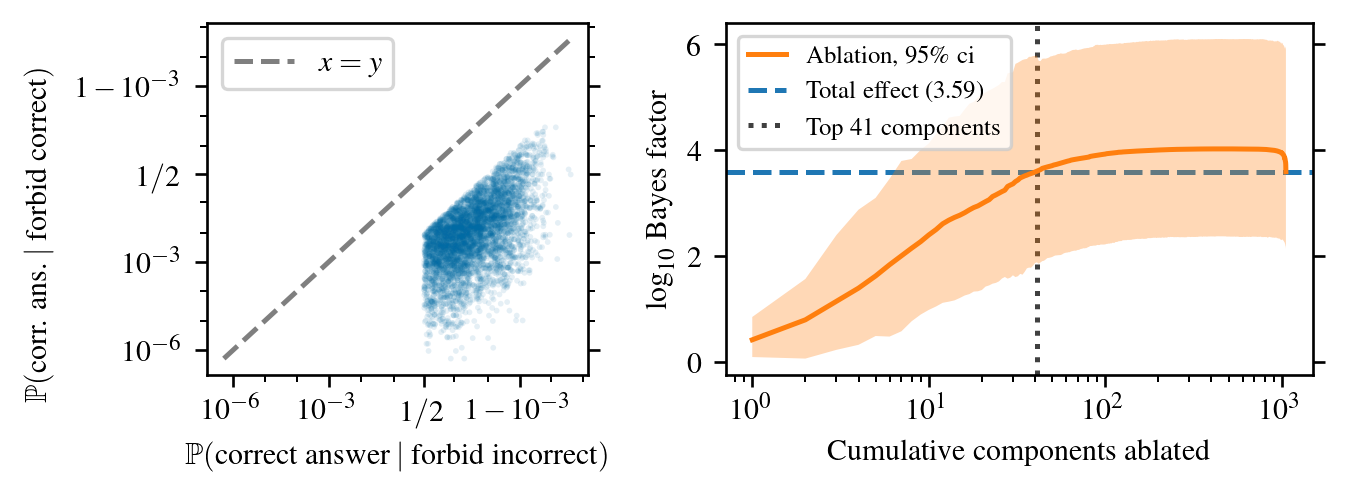

In [8]:
fig, _ = plt.subplots(1, 2, width_ratios=[1.3, 2])

plt.subplot(1, 2, 1)
plot_overall_effect(
    xs=np.concatenate([df.p_correct_nc0, df.p_correct_nc1]),
    ys=np.concatenate([df.p_correct_c, df.p_correct_c]),
    xs_label=r"$\mathbb{P}(\text{correct answer} \;\vert\; \text{forbid incorrect})$",
    ys_label=r"$\mathbb{P}(\text{corr. ans.} \;\vert\; \text{forbid correct})$",
    alpha=0.1,
    s=3,
    edgecolor="none",
)
# Shift ylabel down
plt.gca().yaxis.set_label_coords(x=-0.4, y=0.4)
plt.legend()

plt.subplot(1, 2, 2)
for _, xs_nc_c, xs_c_nc in [
    (
        "Effect of cumulative first-order ablations",
        log_bf_nc_c_cum,
        log_bf_c_nc_cum,
    ),
]:
    utils.plot_with_err(
        np.arange(len(LABELS)) + 1,
        -xs_nc_c / np.log(10),
        label=r"Ablation, 95\% ci",
        color="tab:orange",
    )
    # utils.plot_with_err(
    #     np.arange(len(LABELS)) + 1,
    #     xs_c_nc / np.log(10),
    #     label="base: c.; patch: n.c.",
    #     linestyle="--",
    #     ci=0.95,
    # )

    avg_total_log10_bf = -np.concatenate(
        [df.log_bf0, df.log_bf1]
    ).mean() / np.log(10)
    # min_cum_heads_needed = 1 + max(
    #     torch.arange(len(LABELS))[
    #         (-xs_nc_c.mean(axis=0) / np.log(10) > avg_total_log10_bf)
    #     ][0],
    #     torch.arange(len(LABELS))[
    #         (xs_c_nc.mean(axis=0) / np.log(10) > avg_total_log10_bf)
    #     ][0],
    # )
    min_cum_heads_needed = (
        1
        + torch.arange(len(LABELS))[
            (-xs_nc_c.mean(axis=0) / np.log(10) > avg_total_log10_bf)
        ][0]
    )

    plt.axhline(
        avg_total_log10_bf,
        color="tab:blue",
        linestyle="--",
        label=f"Total effect ({avg_total_log10_bf:.2f})",
        alpha=1,
        zorder=-1,
    )
    plt.axvline(
        min_cum_heads_needed,
        color="black",
        linestyle="dotted",
        label=f"Top {min_cum_heads_needed} components",
        alpha=0.75,
        zorder=-2,
    )

    plt.xscale("log")
    plt.ylabel(r"$\log_{10}$ Bayes factor")
    plt.xlabel(r"Cumulative components ablated")
    plt.legend(
        fontsize="7.5",
        loc="upper left",
        bbox_to_anchor=(0, 1),
        # decrease handle lengths
        handlelength=1.5,
    )

fig.set_figheight(fig.get_figheight() * 0.65)

fig.get_layout_engine().set(wspace=0.07)

fig.show()
figname = f'./plots/overall-effect-and-comp-importance-{SAVED_NAME}.pdf'
plt.savefig(figname, backend="pgf")

### TODO: Generate appendix plots as well.

In [9]:
filt = np.minimum(df_raw.p_correct_nc0, df_raw.p_correct_nc1) > 0.5
df2 = df_raw[filt].reset_index(drop=True)

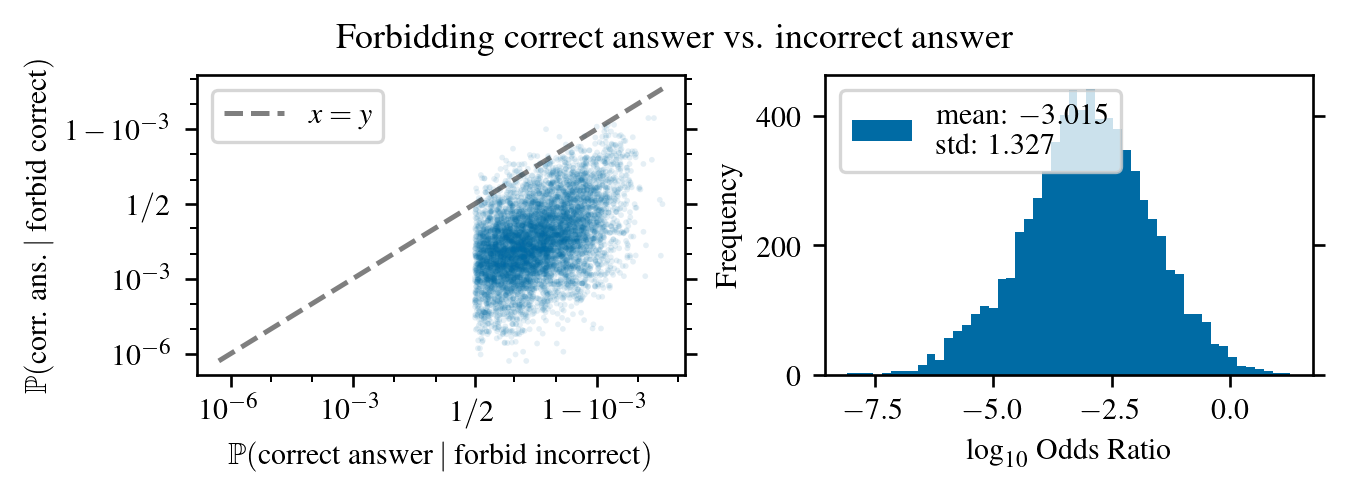

In [10]:
fig, _ = plt.subplots(1, 2)

plt.subplot(1, 2, 1)
log10_bfs = np.concatenate([df2.log_bf0, df2.log_bf1]) / np.log(10)
plot_overall_effect(
    xs=np.concatenate([df2.p_correct_nc0, df2.p_correct_nc1]),
    ys=np.concatenate([df2.p_correct_c, df2.p_correct_c]),
    xs_label=r"$\mathbb{P}(\text{correct answer} \;\vert\; \text{forbid incorrect})$",
    ys_label=r"$\mathbb{P}(\text{corr. ans.} \;\vert\; \text{forbid correct})$",
    alpha=0.1,
    s=3,
    edgecolor="none",
    rasterize=True,
)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(
    log10_bfs,
    bins=50,
    label="\n".join(
        [
            f"mean: ${log10_bfs.mean() : .3f}$",
            f"std: ${log10_bfs.std() : .3f}$",
        ]
    ),
)
plt.xlabel("$\log_{10}$ Odds Ratio")
plt.ylabel("Frequency")
plt.legend(
    loc="upper left",
    bbox_to_anchor=(0, 1),
)

plt.suptitle("Forbidding correct answer vs. incorrect answer")
fig.set_figheight(fig.get_figheight() * 0.65)

figname = f'./plots/forbidden-facts-overview-{SAVED_NAME}.pdf'

plt.savefig(
    figname,
    backend="pgf",
    dpi=400,
    bbox_inches="tight",
)